In [1]:
# References:
# https://github.com/huggingface/notebooks/blob/main/transformers_doc/en/pytorch/zero_shot_object_detection.ipynb

In [ ]:
# Transformers installation
! pip install transformers datasets

In [2]:
from transformers import pipeline

checkpoint = "google/owlvit-base-patch32"
detector = pipeline(model=checkpoint, task="zero-shot-object-detection")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


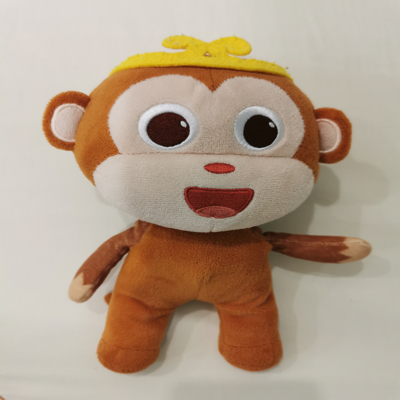

In [3]:
#import skimage
import numpy as np
from PIL import Image
image = Image.open("0.jpg").resize((400,400)).convert("RGB")
image

In [4]:
predictions = detector(
    image,
    candidate_labels=["human face", "toy"],
)
predictions

[{'score': 0.5762187242507935,
  'label': 'toy',
  'box': {'xmin': 38, 'ymin': 37, 'xmax': 370, 'ymax': 375}},
 {'score': 0.12854494154453278,
  'label': 'human face',
  'box': {'xmin': 90, 'ymin': 71, 'xmax': 311, 'ymax': 235}}]

Let's visualize the predictions:

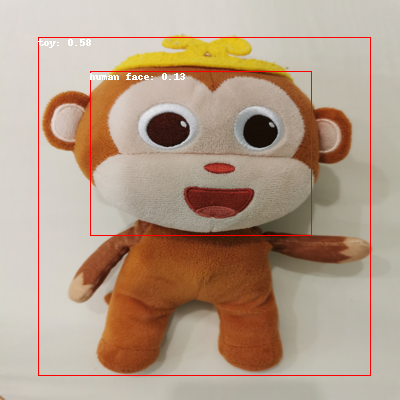

In [5]:
from PIL import ImageDraw

draw = ImageDraw.Draw(image)

for prediction in predictions:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]

    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{label}: {round(score,2)}", fill="white")

image

## Text-prompted zero-shot object detection by hand

Now that you've seen how to use the zero-shot object detection pipeline, let's replicate the same
result manually.

Start by loading the model and associated processor from a [checkpoint on the Hugging Face Hub](https://huggingface.co/models?other=owlvit).
Here we'll use the same checkpoint as before:

In [6]:
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

model = AutoModelForZeroShotObjectDetection.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)

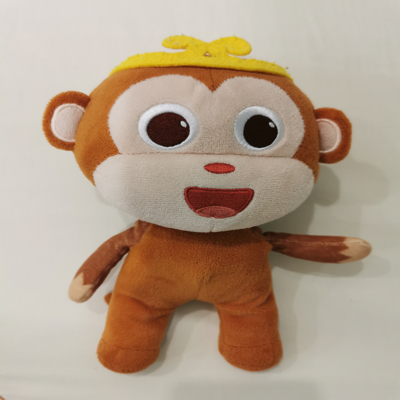

In [18]:
im = Image.open("0.jpg").resize((400,400)).convert("RGB")
im

In [19]:
text_queries = ["human face", "monkey"]
inputs = processor(text=text_queries, images=im, return_tensors="pt")

Pass the inputs through the model, post-process, and visualize the results. Since the image processor resized images before
feeding them to the model, you need to use the [post_process_object_detection()](https://huggingface.co/docs/transformers/main/en/model_doc/owlvit#transformers.OwlViTImageProcessor.post_process_object_detection) method to make sure the predicted bounding
boxes have the correct coordinates relative to the original image:

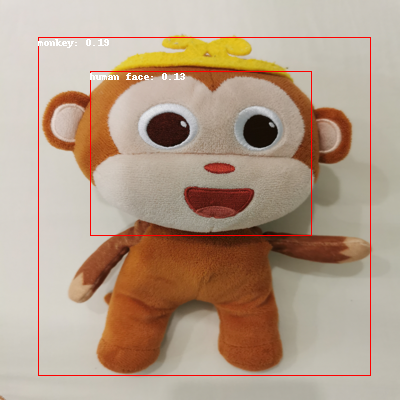

In [20]:
import torch

with torch.no_grad():
    outputs = model(**inputs)
    target_sizes = torch.tensor([im.size[::-1]])
    results = processor.post_process_object_detection(outputs, threshold=0.1, target_sizes=target_sizes)[0]

draw = ImageDraw.Draw(im)

scores = results["scores"].tolist()
labels = results["labels"].tolist()
boxes = results["boxes"].tolist()

for box, score, label in zip(boxes, scores, labels):
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{text_queries[label]}: {round(score,2)}", fill="white")

im